# <center><font color=green>Predict Mortgage Loan Defaults using XGBoost</font>

## <font color=blue>This notebook uses several data science tasks implemented in python code to ingest, cleanse, and transform customer financial data and demographics to predict whether customers will default on their mortgage loan.  The model is evaluated for generalization, deployed to production.  The deployment is tested with sample data to generate a prediction using the REST API created by the deployment

## Load data from Db2 Warehouse

## This is to predict loan default

In [1]:
import dsx_core_utils, requests, jaydebeapi, os, io, sys
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
df1 = None
dataSet = dsx_core_utils.get_remote_data_set_info('BANK LOANS HISTORY')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
if (sys.version_info >= (3, 0)):
  conn = jaydebeapi.connect(dataSource['driver_class'], dataSource['URL'], [dataSource['user'], dataSource['password']])
else:
  conn = jaydebeapi.connect(dataSource['driver_class'], [dataSource['URL'], dataSource['user'], dataSource['password']])
query = 'select * from "' + (dataSet['schema'] + '"."' if (len(dataSet['schema'].strip()) != 0) else '') +  dataSet['table'] + '"'

if (dataSet['query']):
    query = dataSet['query']
df1 = pd.read_sql(query, con=conn)
df1.head()


,SATISFACTION,CHURN,AVG_CASH_BAL,AGE,AGE_RNG,GENDER,NUM_PRODUCTS,CUST_ACQ_YR,NUM_UNIQ_PRODUCTS,EQUITIES_BAL,...,CUST_TYPE,HOME_BRANCH_CTY,HOME_BRANCH_ST,SALESPERSON_ID,NUM_LATE_PYMNTS,NUM_CARD_APPLS,BANKRUPTCY_LAST_7YRS,MONTHLY_MORTGAGE_PYMNT,CREDIT_SCORE,DEFAULT
0,3.0,1,25K,56,50-59,Male,1,2004,53,7000,...,Personal,Orlando,FL,ID7,34,30,No,125.0,861,yes
1,2.0,1,1K,71,70-79,Female,2,2008,36,4000,...,Personal,Tampa,FL,ID14,0,0,No,126.0,873,no
2,2.0,1,1K,27,20-29,Male,2,2003,40,6000,...,Personal,Tampa,FL,ID10,0,0,No,120.0,873,no
3,2.0,0,1K,76,70-79,Female,2,2010,20,3000,...,Personal,Tampa,FL,ID10,57,65,No,143.0,873,yes
4,3.0,1,1K,52,50-59,Female,1,2008,23,2000,...,Personal,Orlando,FL,ID11,0,0,No,137.0,834,no


In [2]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 25 columns):
SATISFACTION              65535 non-null float64
CHURN                     65535 non-null int64
AVG_CASH_BAL              65535 non-null object
AGE                       65535 non-null int64
AGE_RNG                   65535 non-null object
GENDER                    65535 non-null object
NUM_PRODUCTS              65535 non-null int64
CUST_ACQ_YR               65535 non-null int64
NUM_UNIQ_PRODUCTS         65535 non-null int64
EQUITIES_BAL              65535 non-null int64
INIT_MORTG_AMT            65535 non-null object
NUM_ADDR_CHNGS            65535 non-null int64
HOUSEHOLD_ID              65535 non-null int64
CLNTS_IN_HSHLD            65535 non-null int64
AVG_CARD_BAL              65535 non-null int64
CUST_TYPE                 65535 non-null object
HOME_BRANCH_CTY           65535 non-null object
HOME_BRANCH_ST            65535 non-null object
SALESPERSON_ID            65535 non-

In [3]:
df1.describe(include='all')

,SATISFACTION,CHURN,AVG_CASH_BAL,AGE,AGE_RNG,GENDER,NUM_PRODUCTS,CUST_ACQ_YR,NUM_UNIQ_PRODUCTS,EQUITIES_BAL,...,CUST_TYPE,HOME_BRANCH_CTY,HOME_BRANCH_ST,SALESPERSON_ID,NUM_LATE_PYMNTS,NUM_CARD_APPLS,BANKRUPTCY_LAST_7YRS,MONTHLY_MORTGAGE_PYMNT,CREDIT_SCORE,DEFAULT
count,65535.000000,65535.000000,65535,65535.000000,65535,65535,65535.000000,65535.000000,65535.000000,65535.000000,...,65535,65535,65535,65535,65535.000000,65535.000000,65535,63748.000000,65535.000000,65535
unique,NaN,NaN,4,NaN,8,2,NaN,NaN,NaN,NaN,...,3,283,53,23,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,1K,NaN,40-49,Female,NaN,NaN,NaN,NaN,...,Personal,Chicago,TX,ID6,NaN,NaN,No,NaN,NaN,no
freq,NaN,NaN,44836,NaN,13817,37005,NaN,NaN,NaN,NaN,...,53247,4566,9147,4777,NaN,NaN,63928,NaN,NaN,43027
mean,3.377173,0.502953,NaN,46.174273,NaN,NaN,1.277256,2007.215656,20.058122,9333.897917,...,NaN,NaN,NaN,NaN,15.626535,16.537758,NaN,103.973803,727.195544,NaN
std,0.966522,0.499995,NaN,17.309281,NaN,NaN,0.548670,2.981600,14.413566,8769.488145,...,NaN,NaN,NaN,NaN,39.511740,40.052286,NaN,71.874038,593.558184,NaN
min,1.000000,0.000000,NaN,15.000000,NaN,NaN,0.000000,2003.000000,0.000000,1000.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,8.000000,31.000000,NaN
25%,3.000000,0.000000,NaN,33.000000,NaN,NaN,1.000000,2004.000000,9.000000,4000.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,53.000000,305.000000,NaN
50%,4.000000,1.000000,NaN,45.000000,NaN,NaN,1.000000,2007.000000,17.000000,7000.000000,...,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,85.000000,571.000000,NaN
75%,4.000000,1.000000,NaN,58.000000,NaN,NaN,2.000000,2010.000000,29.000000,10000.000000,...,NaN,NaN,NaN,NaN,14.000000,16.000000,NaN,132.000000,954.000000,NaN


## <font color=blue size=5>Drop household_id, age, num_uniq_products</font>

In [4]:
df1.pop('HOUSEHOLD_ID')
df1.pop('AGE')
df1.pop('NUM_UNIQ_PRODUCTS')

0        53
1        36
2        40
3        20
4        23
5         8
6        35
7        26
8        30
9         7
10        1
11        6
12       23
13        1
14       27
15       45
16       20
17       24
18       12
19       12
20       44
21       18
22       15
23       38
24       36
25       14
26       38
27       23
28       14
29        4
         ..
65505    46
65506     1
65507     6
65508    25
65509    23
65510    29
65511    31
65512     4
65513     4
65514    17
65515    29
65516    31
65517    40
65518    55
65519    48
65520    35
65521     8
65522    17
65523    13
65524     9
65525    28
65526     2
65527     3
65528    52
65529    27
65530    11
65531     8
65532    10
65533    33
65534     6
Name: NUM_UNIQ_PRODUCTS, Length: 65535, dtype: int64

## <font color=blue size=5>Explore the data with visualizations</font>

In [5]:
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully



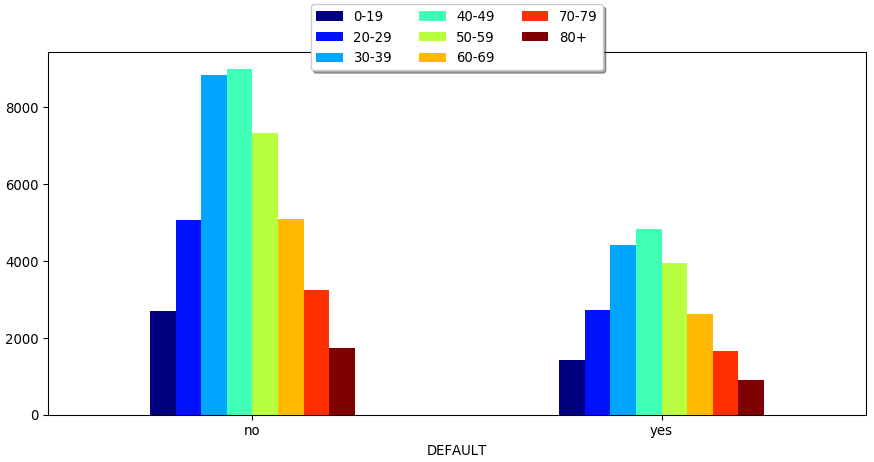

In [6]:
display(df1)

## <font color=blue size=5>Replace missing data with mean and scale with MinMaxScaler</font>

In [10]:
MEAN_MORTGAGE_PYMNT = df1["MONTHLY_MORTGAGE_PYMNT"].astype("float").mean(axis = 0)
print("MEAN MORTGAGE_PYMNT = " , MEAN_MORTGAGE_PYMNT)

MEAN MORTGAGE_PYMNT =  103.9738030997051


In [12]:
import numpy as np
df1.replace("?", np.nan, inplace = True)
df1["MONTHLY_MORTGAGE_PYMNT"].replace(np.nan, MEAN_MORTGAGE_PYMNT, inplace = True)

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler=MinMaxScaler()

In [17]:
df1[['SATISFACTION','NUM_PRODUCTS','CUST_ACQ_YR','EQUITIES_BAL','NUM_ADDR_CHNGS','CLNTS_IN_HSHLD','AVG_CARD_BAL','NUM_LATE_PYMNTS','NUM_CARD_APPLS','MONTHLY_MORTGAGE_PYMNT','CREDIT_SCORE']] = scaler.fit_transform(df1[['SATISFACTION','NUM_PRODUCTS','CUST_ACQ_YR','EQUITIES_BAL','NUM_ADDR_CHNGS','CLNTS_IN_HSHLD','AVG_CARD_BAL','NUM_LATE_PYMNTS','NUM_CARD_APPLS','MONTHLY_MORTGAGE_PYMNT','CREDIT_SCORE']])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## <font color=blue size=5> Encode categorical data</font>

In [18]:
for feature in df1.columns: # Loop through all columns in the dataframe
    if df1[feature].dtype == 'object': # Only apply for columns with categorical strings
        df1[feature] = pd.Categorical(df1[feature]).codes # Replace strings with an integer

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 22 columns):
SATISFACTION              65535 non-null float64
CHURN                     65535 non-null int64
AVG_CASH_BAL              65535 non-null int8
AGE_RNG                   65535 non-null int8
GENDER                    65535 non-null int8
NUM_PRODUCTS              65535 non-null float64
CUST_ACQ_YR               65535 non-null float64
EQUITIES_BAL              65535 non-null float64
INIT_MORTG_AMT            65535 non-null int8
NUM_ADDR_CHNGS            65535 non-null float64
CLNTS_IN_HSHLD            65535 non-null float64
AVG_CARD_BAL              65535 non-null float64
CUST_TYPE                 65535 non-null int8
HOME_BRANCH_CTY           65535 non-null int16
HOME_BRANCH_ST            65535 non-null int8
SALESPERSON_ID            65535 non-null int8
NUM_LATE_PYMNTS           65535 non-null float64
NUM_CARD_APPLS            65535 non-null float64
BANKRUPTCY_LAST_7YRS      65535 no

In [20]:
df1.head()

,SATISFACTION,CHURN,AVG_CASH_BAL,AGE_RNG,GENDER,NUM_PRODUCTS,CUST_ACQ_YR,EQUITIES_BAL,INIT_MORTG_AMT,NUM_ADDR_CHNGS,...,CUST_TYPE,HOME_BRANCH_CTY,HOME_BRANCH_ST,SALESPERSON_ID,NUM_LATE_PYMNTS,NUM_CARD_APPLS,BANKRUPTCY_LAST_7YRS,MONTHLY_MORTGAGE_PYMNT,CREDIT_SCORE,DEFAULT
0,0.50,1,2,4,1,0.25,0.111111,0.056604,2,0.0,...,1,200,9,20,0.033432,0.029674,0,0.177005,0.167609,1
1,0.25,1,1,6,0,0.50,0.555556,0.028302,2,0.0,...,1,256,9,5,0.000000,0.000000,0,0.178517,0.170032,0
2,0.25,1,1,1,1,0.50,0.000000,0.047170,2,0.0,...,1,256,9,1,0.000000,0.000000,0,0.169440,0.170032,0
3,0.25,0,1,6,0,0.50,0.777778,0.018868,2,0.0,...,1,256,9,1,0.056047,0.064293,0,0.204236,0.170032,1
4,0.50,1,1,4,0,0.25,0.555556,0.009434,2,0.0,...,1,200,9,2,0.000000,0.000000,0,0.195159,0.162157,0


## <font color=blue size=5>Randomly split data into train and test.  Set seed for reproducibility</font>

In [21]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df1, test_size=0.3)
print ("Training Sample" , df_train.count())
print ("Test Sample", df_test.count())

Training Sample SATISFACTION              45874
CHURN                     45874
AVG_CASH_BAL              45874
AGE_RNG                   45874
GENDER                    45874
NUM_PRODUCTS              45874
CUST_ACQ_YR               45874
EQUITIES_BAL              45874
INIT_MORTG_AMT            45874
NUM_ADDR_CHNGS            45874
CLNTS_IN_HSHLD            45874
AVG_CARD_BAL              45874
CUST_TYPE                 45874
HOME_BRANCH_CTY           45874
HOME_BRANCH_ST            45874
SALESPERSON_ID            45874
NUM_LATE_PYMNTS           45874
NUM_CARD_APPLS            45874
BANKRUPTCY_LAST_7YRS      45874
MONTHLY_MORTGAGE_PYMNT    45874
CREDIT_SCORE              45874
DEFAULT                   45874
dtype: int64
Test Sample SATISFACTION              19661
CHURN                     19661
AVG_CASH_BAL              19661
AGE_RNG                   19661
GENDER                    19661
NUM_PRODUCTS              19661
CUST_ACQ_YR               19661
EQUITIES_BAL              19661

## <font color=blue size=5>Split out target</font> 

In [22]:
y_train = df_train.pop('DEFAULT')
y_test =  df_test.pop('DEFAULT')

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45874 entries, 29911 to 35086
Data columns (total 21 columns):
SATISFACTION              45874 non-null float64
CHURN                     45874 non-null int64
AVG_CASH_BAL              45874 non-null int8
AGE_RNG                   45874 non-null int8
GENDER                    45874 non-null int8
NUM_PRODUCTS              45874 non-null float64
CUST_ACQ_YR               45874 non-null float64
EQUITIES_BAL              45874 non-null float64
INIT_MORTG_AMT            45874 non-null int8
NUM_ADDR_CHNGS            45874 non-null float64
CLNTS_IN_HSHLD            45874 non-null float64
AVG_CARD_BAL              45874 non-null float64
CUST_TYPE                 45874 non-null int8
HOME_BRANCH_CTY           45874 non-null int16
HOME_BRANCH_ST            45874 non-null int8
SALESPERSON_ID            45874 non-null int8
NUM_LATE_PYMNTS           45874 non-null float64
NUM_CARD_APPLS            45874 non-null float64
BANKRUPTCY_LAST_7YRS      4587

In [24]:
import xgboost as xgb

## <font color=blue size=5>Create our DMatrix to make XGBoost more efficient</font>

In [25]:
xgdmat = xgb.DMatrix( df_train, y_train)

In [26]:
xgb_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

In [27]:
cv_xgb = xgb.cv(params = xgb_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:07:49] /workspace/sr

In [28]:
cv_xgb.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.003858,0.001849,0.003750,0.002056
1,0.002899,0.000145,0.002899,0.000579
2,0.003095,0.000342,0.003139,0.000921
3,0.003161,0.000467,0.003335,0.001269
4,0.002828,0.000197,0.002790,0.000558


In [29]:
cv_xgb.tail(1)

,train-error-mean,train-error-std,test-error-mean,test-error-std
52,0.0,0.0,0.0,0.0


In [30]:
xgb_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_xgb = xgb.train(xgb_params, xgdmat, num_boost_round = 400)

[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[16:08:35] /workspac

In [31]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

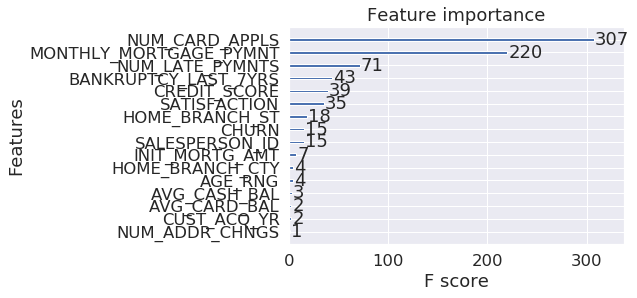

In [32]:
xgb.plot_importance(final_xgb)

In [33]:
importances = final_xgb.get_fscore()
importances

{'SATISFACTION': 35,
 'BANKRUPTCY_LAST_7YRS': 43,
 'SALESPERSON_ID': 15,
 'AGE_RNG': 4,
 'INIT_MORTG_AMT': 7,
 'AVG_CASH_BAL': 3,
 'NUM_CARD_APPLS': 307,
 'MONTHLY_MORTGAGE_PYMNT': 220,
 'NUM_LATE_PYMNTS': 71,
 'CREDIT_SCORE': 39,
 'HOME_BRANCH_CTY': 4,
 'CUST_ACQ_YR': 2,
 'HOME_BRANCH_ST': 18,
 'CHURN': 15,
 'AVG_CARD_BAL': 2,
 'NUM_ADDR_CHNGS': 1}

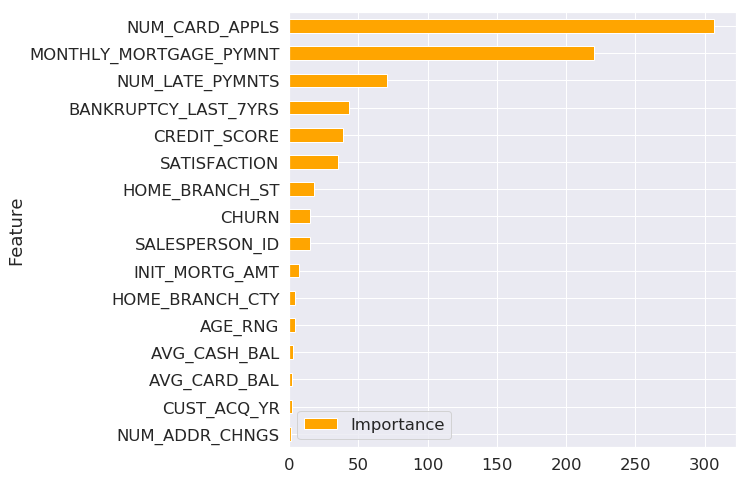

In [34]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

## <font color=blue size=5>Evaluate Accuracy - Generate predictions on test data</font>

In [35]:
testdmat = xgb.DMatrix(df_test)

In [36]:
from sklearn.metrics import accuracy_score
y_pred = final_xgb.predict(testdmat) # Predict using our testdmat
y_pred

array([3.4295987e-05, 1.6952070e-05, 2.1169923e-05, ..., 1.6125596e-05,
       1.6222028e-05, 5.9274866e-05], dtype=float32)

## <font color=blue size=5>Convert to probabilities</font>

In [37]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

## <font color=blue size=5>Calculate Accuracy Score</font>

In [38]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(1.0, 0.0)

## <font color=blue size=5>Save model</font>

In [39]:
from dsx_ml.ml import save

In [40]:
save(model = final_xgb,
     name = 'XGBLoanDefault',
     x_test = df_test,
     y_test = pd.DataFrame(y_test),
     algorithm_type = 'Classification',
     params = {})

Using TensorFlow backend.


{'path': '/user-home/1002/DSX_Projects/FSS_DEMO_NF/models/XGBLoanDefault/1',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python36/xgboost-0.80/FSS_DEMO_NF/XGBLoanDefault/1'}

## <font color=blue size=5>Make Predictions on New Data</font>

In [51]:
cust01 = {
"SATISFACTION" : .25,
"CHURN" : 1,
"AVG_CASH_BAL" : 1,
"AGE_RNG" : 6,
"GENDER" : 0,
"NUM_PRODUCTS" : .25,
"CUST_ACQ_YR" : .888889,
"EQUITIES_BAL" : .084906,
"INIT_MORTG_AMT" : 2,
"NUM_ADDR_CHNGS" : .00295,
"CLNTS_IN_HSHLD" : 0,
"AVG_CARD_BAL" : .33520,
"CUST_TYPE" : 2,
"HOME_BRANCH_CTY" : 231,
"HOME_BRANCH_ST" : 4,
"SALESPERSON_ID" : 9,
"NUM_LATE_PYMNTS" : .001967,
"NUM_CARD_APPLS" : .048467,
"BANKRUPTCY_LAST_7YRS" : 0,
"MONTHLY_MORTGAGE_PYMNT" : .072617,
"CREDIT_SCORE" : .033926
}


In [52]:
cust01 = {
"SATISFACTION" : 4,
"CHURN" : 1,
"AVG_CASH_BAL" : 1,
"AGE_RNG" : 6,
"GENDER" : 0,
"NUM_PRODUCTS" : 3,
"CUST_ACQ_YR" : 2010,
"EQUITIES_BAL" : 9000,
"INIT_MORTG_AMT" : 2,
"NUM_ADDR_CHNGS" : 2,
"CLNTS_IN_HSHLD" : 2,
"AVG_CARD_BAL" : 1500,
"CUST_TYPE" : 2,
"HOME_BRANCH_CTY" : 231,
"HOME_BRANCH_ST" : 4,
"SALESPERSON_ID" : 9,
"NUM_LATE_PYMNTS" : 10,
"NUM_CARD_APPLS" : 5,
"BANKRUPTCY_LAST_7YRS" : 0,
"MONTHLY_MORTGAGE_PYMNT" : 350,
"CREDIT_SCORE" : 700
}

In [57]:
df2=pd.DataFrame([cust01])

In [58]:
df3=df2[['SATISFACTION','CHURN','AVG_CASH_BAL','AGE_RNG','GENDER','NUM_PRODUCTS','CUST_ACQ_YR','EQUITIES_BAL','INIT_MORTG_AMT','NUM_ADDR_CHNGS','CLNTS_IN_HSHLD','AVG_CARD_BAL','CUST_TYPE','HOME_BRANCH_CTY','HOME_BRANCH_ST','SALESPERSON_ID','NUM_LATE_PYMNTS','NUM_CARD_APPLS','BANKRUPTCY_LAST_7YRS','MONTHLY_MORTGAGE_PYMNT','CREDIT_SCORE']]
df3

,SATISFACTION,CHURN,AVG_CASH_BAL,AGE_RNG,GENDER,NUM_PRODUCTS,CUST_ACQ_YR,EQUITIES_BAL,INIT_MORTG_AMT,NUM_ADDR_CHNGS,...,AVG_CARD_BAL,CUST_TYPE,HOME_BRANCH_CTY,HOME_BRANCH_ST,SALESPERSON_ID,NUM_LATE_PYMNTS,NUM_CARD_APPLS,BANKRUPTCY_LAST_7YRS,MONTHLY_MORTGAGE_PYMNT,CREDIT_SCORE
0,4,1,1,6,0,3,2010,9000,2,2,...,1500,2,231,4,9,10,5,0,350,700


In [59]:
new_data = xgb.DMatrix(df3)

## <font color=blue size=5> Show results</font>

In [60]:
cust01_churn = final_xgb.predict(new_data)

if cust01_churn[0] > .50:
    outcome = "Default"
else: 
    outcome = "Make Payments"

output_str = (u'Cust01 is predicted to ' + outcome + ' with probability = ' + str(cust01_churn[0]))

print(output_str)

Cust01 is predicted to Default with probability = 0.99996066
